<a href="https://colab.research.google.com/github/raulfruiz/spotify-analysis/blob/main/spotifyAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spotipy # wrapper that allows to access the Spotify API

In [2]:
import requests
CLIENT_ID = '4e83d35eacfd41348ba5a24af18695d5'
CLIENT_SECRET = '0d0222e604b546a19d377f594a4c3582'

AUTH_URL = 'https://accounts.spotify.com/api/token'

In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials #Getting access to the project in the API
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [8]:
artist_name = []
track_name = []
track_popularity = []
artist_id = []
track_id = []
for i in range(0,1000,50):
    track_results = sp.search(q='year:1999', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        artist_id.append(t['artists'][0]['id'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        track_popularity.append(t['popularity'])
        

In [9]:
import pandas as pd
#creating the dataframe
track_df = pd.DataFrame({'artist_name' : artist_name, 'track_name' : track_name, 'track_id' : track_id, 'track_popularity' : track_popularity, 'artist_id' : artist_id})
print(track_df.shape)
track_df.head(5)

(1000, 5)


,artist_name,track_name,track_id,track_popularity,artist_id
0,Dr. Dre,Still D.R.E.,503OTo2dSqe7qk76rgsbep,84,6DPYiyq5kWVQS4RGwxzPC7
1,blink-182,All The Small Things,2m1hi0nfMR9vdGC8UcrnwU,81,6FBDaR13swtiWwGhX1WQsP
2,TLC,No Scrubs,1KGi9sZVMeszgZOWivFpxs,79,0TImkz4nPqjegtVSMZnMRq
3,Dr. Dre,Forgot About Dre,7iXF2W9vKmDoGAhlHdpyIa,79,6DPYiyq5kWVQS4RGwxzPC7
4,Red Hot Chili Peppers,Californication,48UPSzbZjgc449aqz8bxox,82,0L8ExT028jH3ddEcZwqJJ5


In [10]:
artist_popularity = []
artist_genres = []
artist_followers = []
for a_id in track_df.artist_id:
  artist = sp.artist(a_id)
  artist_popularity.append(artist['popularity'])
  artist_genres.append(artist['genres'])
  artist_followers.append(artist['followers']['total'])

In [ ]:
track_df = track_df.assign(artist_popularity=artist_popularity, artist_genres=artist_genres, artist_followers=artist_followers)
track_df.head()

In [ ]:
track_features = []
for t_id in track_df['track_id']:
  af = sp.audio_features(t_id)
  track_features.append(af)
tf_df = pd.DataFrame(columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'])
for item in track_features:
  for feat in item:
    tf_df = tf_df.append(feat, ignore_index=True)
tf_df.head()

In [ ]:
cols_to_drop2 = ['key','mode','type', 'uri','track_href','analysis_url']
tf_df = tf_df.drop(columns=cols_to_drop2)
print(track_df.info())
print(tf_df.info())

In [ ]:
track_df['artist_name'] = track_df['artist_name'].astype("string")
track_df['track_name'] = track_df['track_name'].astype("string")
track_df['track_id'] = track_df['track_id'].astype("string")
track_df['artist_id'] = track_df['artist_id'].astype("string")
tf_df['duration_ms'] = pd.to_numeric(tf_df['duration_ms'])
tf_df['instrumentalness'] = pd.to_numeric(tf_df['instrumentalness'])
tf_df['time_signature'] = tf_df['time_signature'].astype("category")
print(track_df.info())
print(tf_df.info())

In [ ]:
track_df.sort_values(by=['track_popularity'], ascending=False)[['track_name', 'artist_name']].head(20)

In [ ]:
by_art_fol = pd.DataFrame(track_df.sort_values(by=['artist_followers'], ascending=False)[['artist_followers','artist_popularity', 'artist_name','artist_genres']])
by_art_fol.astype(str).drop_duplicates().head(20)

In [ ]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])
to_1D(track_df['artist_genres']).value_counts().head(20)

Text(0.5, 1.0, 'Top genres')

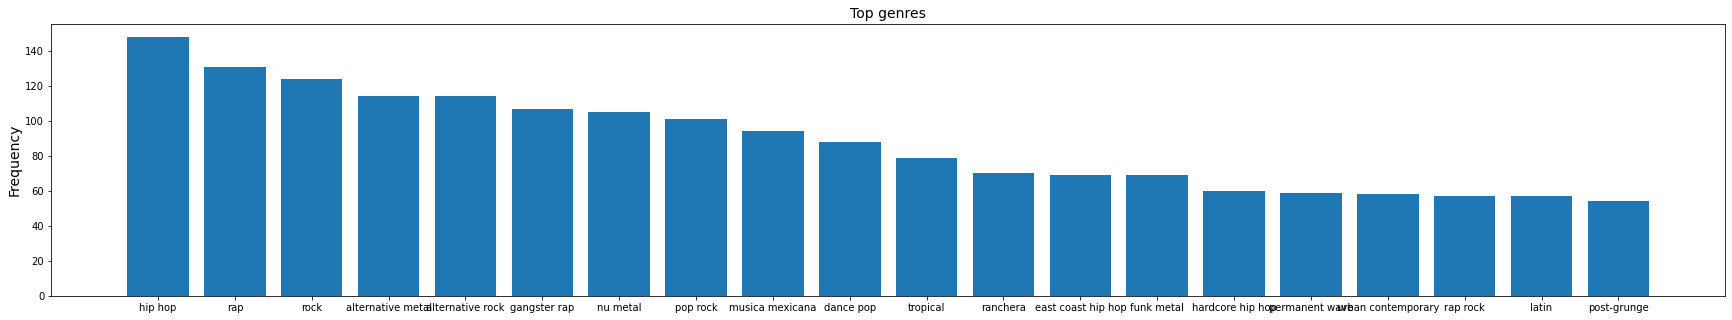

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (30,5))
ax.bar(to_1D(track_df['artist_genres']).value_counts().index[:20],
        to_1D(track_df['artist_genres']).value_counts().values[:20])
ax.set_ylabel("Frequency", size = 14)
ax.set_title("Top genres", size = 14)

In [ ]:
top_10_genres = list(to_1D(track_df['artist_genres']).value_counts().index[:20])
top_artists_by_genre = []
for genre in top_10_genres:
  for index, row in by_art_fol.iterrows():
    if genre in row['artist_genres']:
      top_artists_by_genre.append({'artist_name':row['artist_name'], 'artist_genre':genre})
      break
pd.json_normalize(top_artists_by_genre)

In [ ]:
top_10_genres = list(to_1D(track_df['artist_genres']).value_counts().index[:20])
top_artists_by_genre = []
for genre in top_10_genres:
  for index, row in by_art_fol.iterrows():
    if genre in row['artist_genres']:
      top_artists_by_genre.append({'artist_name':row['artist_name'], 'artist_genre':genre})
      break
pd.json_normalize(top_artists_by_genre)

In [ ]:
import seaborn as sn
sn.set(rc = {'figure.figsize':(12,10)})
sn.heatmap(tf_df.corr(), annot=True)
plt.show()

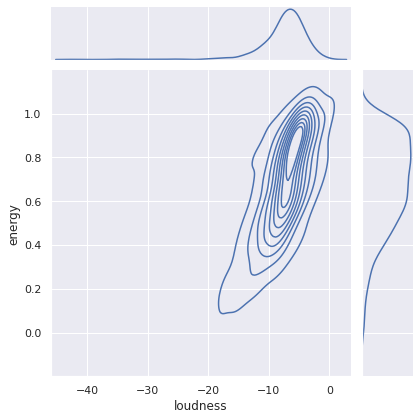

In [22]:
sn.set(rc = {'figure.figsize':(20,20)})
sn.jointplot(data=tf_df, x="loudness", y="energy", kind="kde")

In [23]:
feat_cols = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
top_100_feat = pd.DataFrame(columns=feat_cols)
by_track_pop= pd.DataFrame()
for i, track in by_track_pop[:100].iterrows():
  features = tf_df[tf_df['id'] == track['track_id']]
  top_100_feat = top_100_feat.append(features, ignore_index=True)
top_100_feat = top_100_feat[feat_cols]

from sklearn import preprocessing
mean_vals = pd.DataFrame(columns=feat_cols)
mean_vals = mean_vals.append(top_100_feat.mean(), ignore_index=True)
mean_vals = mean_vals.append(tf_df[feat_cols].mean(), ignore_index=True)
print(mean_vals)

import plotly.graph_objects as go
import plotly.offline as pyo
fig = go.Figure(
    data=[
        go.Scatterpolar(r=mean_vals.iloc[0], theta=feat_cols, fill='toself', name='Top 100'),
        go.Scatterpolar(r=mean_vals.iloc[1], theta=feat_cols, fill='toself', name='All'),
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Feature comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

pyo.plot(fig)
fig.show()

   danceability   energy  speechiness  acousticness  instrumentalness  \
0           NaN      NaN          NaN           NaN               NaN   
1      0.612158  0.67538     0.098983      0.225227          0.059721   

   liveness   valence  
0       NaN       NaN  
1  0.193152  0.602002  


In [27]:
rec = sp.recommendations(seed_artists=["3PhoLpVuITZKcymswpck5b"], seed_genres=["pop"], seed_tracks=["1r9xUipOqoNwggBpENDsvJ"], limit=10)
for track in rec['tracks']:
  print(track['artists'][0]['name'], track['name'])

half•alive creature
Rihanna Work
grandson Darkside
Charli XCX 1999
Little Mix Secret Love Song (feat. Jason Derulo)
Neil Diamond Forever In Blue Jeans
Milky Chance Colorado
Lost Frequencies Are You With Me - Radio Edit
Supertramp Goodbye Stranger - 2010 Remastered
The Score Enemies
